In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# Functions to generate heatmaps

In [3]:
def heatmap_initial_vs_max_epss(data, title):
    epss_day_0 = data.groupby('cve')['epss'].apply(lambda l: l.values[0]).round(1).astype(str)
    max_epss_per_cve = data.groupby('cve')['epss'].max().round(1).astype(str)
    heatmap_data = pd.DataFrame(index=[str(round(i, 1)) for i in np.arange(1.0, -0.1, -0.1)], columns=[str(round(i, 1)) for i in np.arange(0.0, 1.1, 0.1)])
    indexes = data['cve'].unique()
    for cve in indexes:
        init, final = str(epss_day_0[cve]), str(max_epss_per_cve[cve])
        count = 1 if pd.isna(heatmap_data.loc[final, init]) else heatmap_data.loc[final, init] + 1
        heatmap_data.loc[final, init] = count
    heatmap_data = heatmap_data.fillna(0)
    plt.figure(figsize=(8, 5))
    sns.heatmap(heatmap_data, annot=True, square=True, fmt='d', norm=LogNorm())
    plt.xlabel('Initial EPSS')
    plt.ylabel('Max EPSS')
    plt.title(title)
    plt.show()

In [4]:
def heatmap_epss_initial_vs_days_needed(data, title):
    max_epss_per_cve = data.groupby('cve')['epss'].max()
    
    def get_days_before_maximum_epss(series):
        indices_above_threshold = [i for i, v in enumerate(series.values) if v == max_epss_per_cve[series.name]]
        return indices_above_threshold[0] if indices_above_threshold else np.nan

    def compute_days_needed_to_reach_maximum(df):
        return df.groupby('cve')['epss'].apply(get_days_before_maximum_epss).dropna()
    
    epss_day_0 = data.groupby('cve')['epss'].apply(lambda l: l.values[0]).round(1).astype(str)
    days_needed = compute_days_needed_to_reach_maximum(data)
    max_days = days_needed.max()
    step_days = int(max_days / 11)
    indexes = [str(i) for i in range(step_days, (step_days * 11) + step_days, step_days)]
    indexes.reverse()
    heatmap_data = pd.DataFrame(index=indexes, columns=[str(round(i, 1)) for i in np.arange(0.0, 1.1, 0.1)])
    cve_indexes = data['cve'].unique()
    for cve in cve_indexes:
        init = str(epss_day_0[cve])
        days = int((days_needed[cve] // step_days)) * step_days
        if str(days) not in indexes:
            days = int((days_needed[cve] // step_days) + 1) * step_days
        days = str(days)
        count = 1 if pd.isna(heatmap_data.loc[days, init]) else heatmap_data.loc[days, init] + 1
        heatmap_data.loc[days, init] = count
    heatmap_data = heatmap_data.fillna(0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, square=True, fmt='d', norm=LogNorm())
    plt.xlabel('Initial EPSS')
    plt.ylabel('#days to reach max EPSS')
    plt.title(title)
    plt.show()

# Datasets

In [5]:
THRESHOLD = 0.7

In [6]:
df_dataset = pd.read_pickle('datasets/epss_v3.pkl')
df_highest_epss = pd.read_pickle('datasets/epss_v3_highest.pkl')
df_lowest_epss = pd.read_pickle('datasets/epss_v3_lowest.pkl')
with open('datasets/cve_info.csv', 'r') as f:
    df_cve_info = pd.read_csv(f)
df_cve_info['published'] = pd.to_datetime(df_cve_info['published'])
df_cve_info = df_cve_info.sort_values(by=['published'])

In [7]:
cut_date = '2023-03-07'
historical_cve = df_cve_info[df_cve_info['published'] < cut_date]['id'].values
current_cve = df_cve_info[df_cve_info['published'] >= cut_date]['id'].values

In [8]:
df_dataset_historical = df_dataset[df_dataset['cve'].isin(historical_cve)]
df_highest_epss_historical = df_highest_epss[df_highest_epss['cve'].isin(historical_cve)]
df_lowest_epss_historical = df_lowest_epss[df_lowest_epss['cve'].isin(historical_cve)]

df_dataset_current = df_dataset[df_dataset['cve'].isin(current_cve)]
df_highest_epss_current = df_highest_epss[df_highest_epss['cve'].isin(current_cve)]
df_lowest_epss_current = df_lowest_epss[df_lowest_epss['cve'].isin(current_cve)]

In [9]:
from scripts import dataset_creation 

_, cve_pz = dataset_creation.download_dataset_and_extract_cve_pz()
df_pz = df_dataset[df_dataset['cve'].isin(cve_pz)]
highest_cve_pz = set(df_pz.groupby('cve').filter(lambda e: (e['epss'] > THRESHOLD).any())['cve'])
df_highest_pz = df_pz[df_pz['cve'].isin(highest_cve_pz)]
df_lowest_pz = df_pz[~df_pz['cve'].isin(highest_cve_pz)]

_, cve_kev = dataset_creation.download_dataset_and_extract_cve_kev()
df_kev = df_dataset[df_dataset['cve'].isin(cve_kev)]
highest_cve_kev = set(df_kev.groupby('cve').filter(lambda e: (e['epss'] > THRESHOLD).any())['cve'])
df_highest_kev = df_kev[df_kev['cve'].isin(highest_cve_kev)]
df_lowest_kev = df_kev[~df_kev['cve'].isin(highest_cve_kev)]

# Analyses

## Historical CVEs

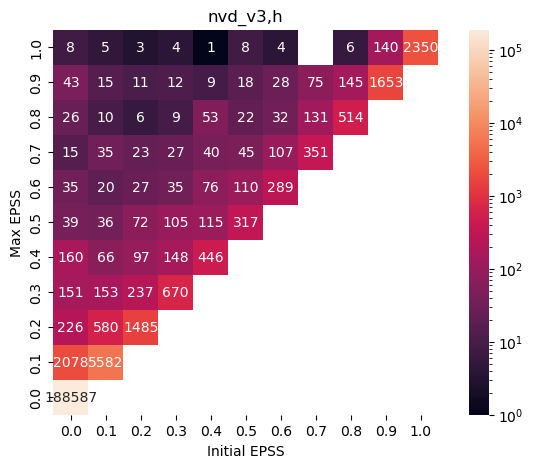

In [38]:
heatmap_initial_vs_max_epss(df_dataset_historical, 'nvd_v3,h')

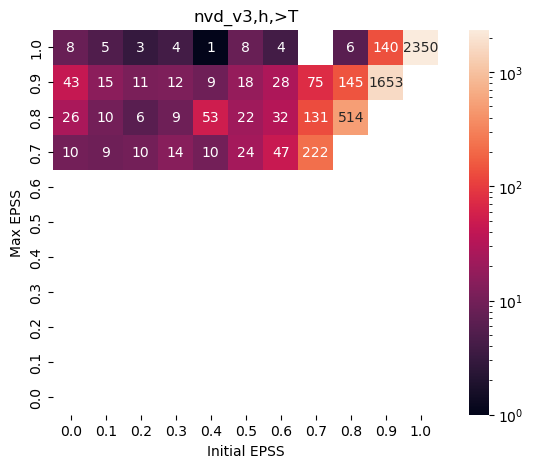

In [39]:
heatmap_initial_vs_max_epss(df_highest_epss_historical, 'nvd_v3,h,>T')

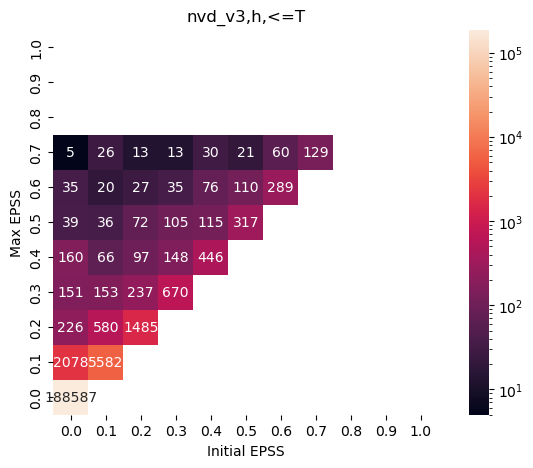

In [40]:
heatmap_initial_vs_max_epss(df_lowest_epss_historical, 'nvd_v3,h,<=T')

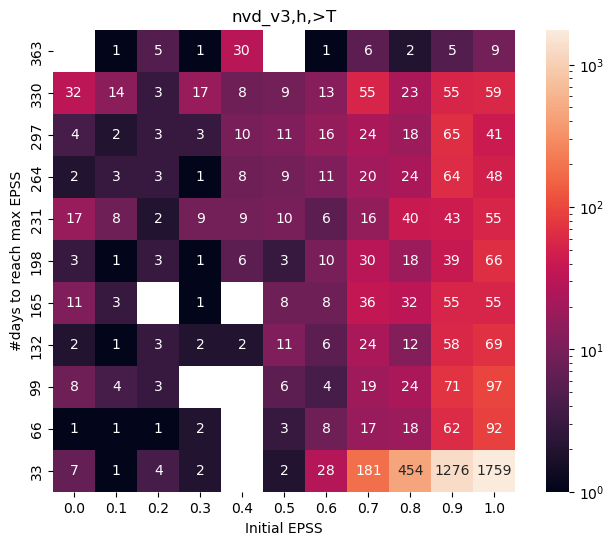

In [41]:
heatmap_epss_initial_vs_days_needed(df_highest_epss_historical, 'nvd_v3,h,>T')

## Historical CVEs growing

In [11]:
highest_cves_under_threshold = df_highest_epss_historical.groupby('cve')['epss'].apply(lambda l: l.values[0]).where(lambda x: x <= THRESHOLD).dropna()

In [12]:
df_highest_historical_cves_growing = df_highest_epss_historical[df_highest_epss_historical['cve'].isin(highest_cves_under_threshold.index)]

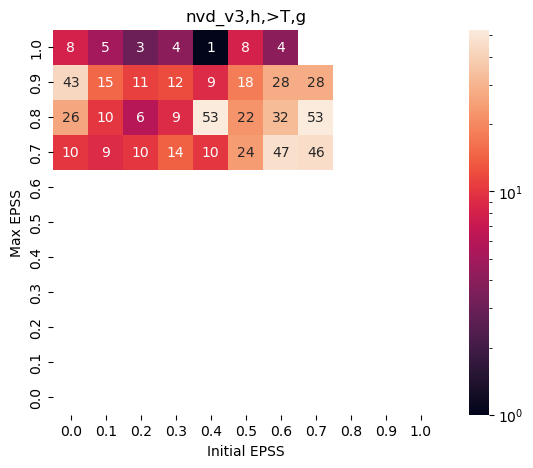

In [68]:
heatmap_initial_vs_max_epss(df_highest_historical_cves_growing, 'nvd_v3,h,>T,g')

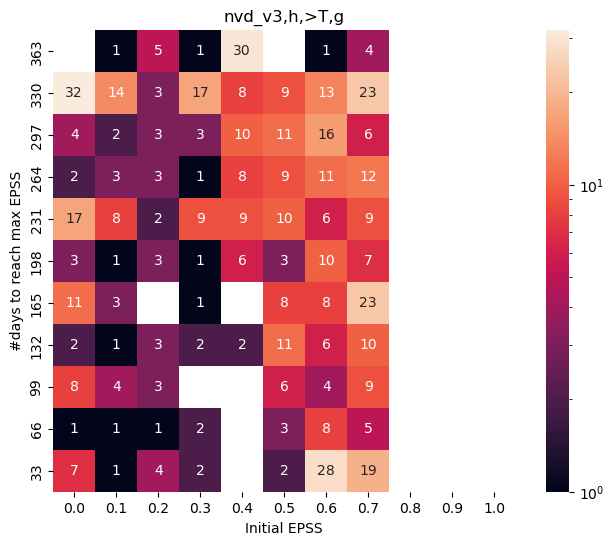

In [13]:
heatmap_epss_initial_vs_days_needed(df_highest_historical_cves_growing, 'nvd_v3,h,>T,g')

## Current CVEs

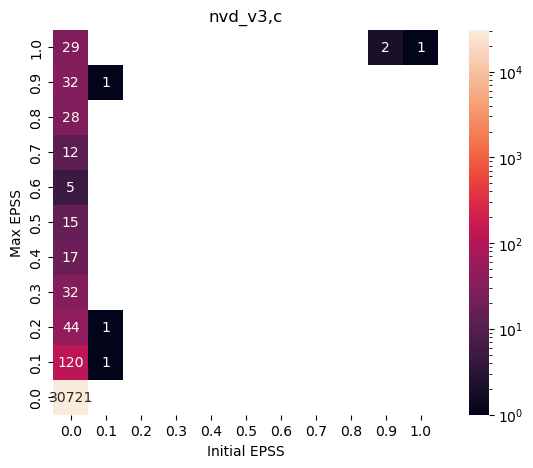

In [42]:
heatmap_initial_vs_max_epss(df_dataset_current, 'nvd_v3,c')

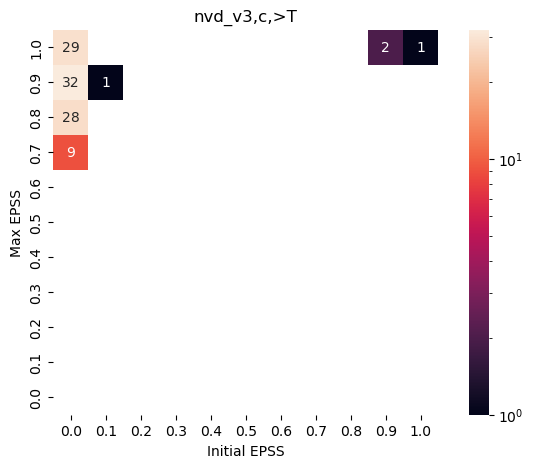

In [43]:
heatmap_initial_vs_max_epss(df_highest_epss_current, 'nvd_v3,c,>T')

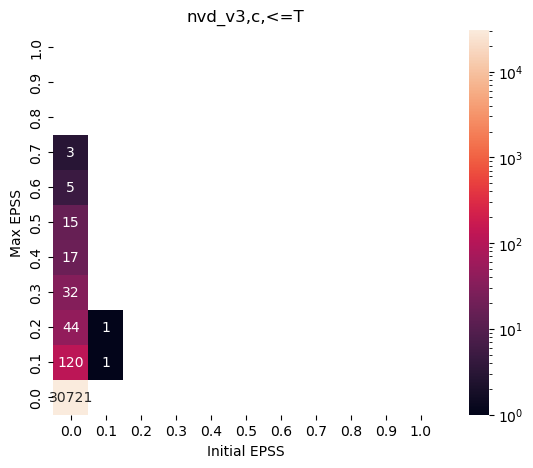

In [44]:
heatmap_initial_vs_max_epss(df_lowest_epss_current, 'nvd_v3,c,<=T')

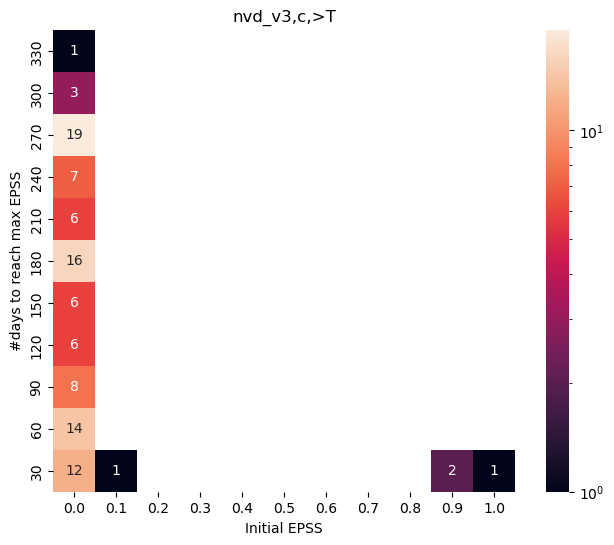

In [45]:
heatmap_epss_initial_vs_days_needed(df_highest_epss_current, 'nvd_v3,c,>T')

## Google Project Zero

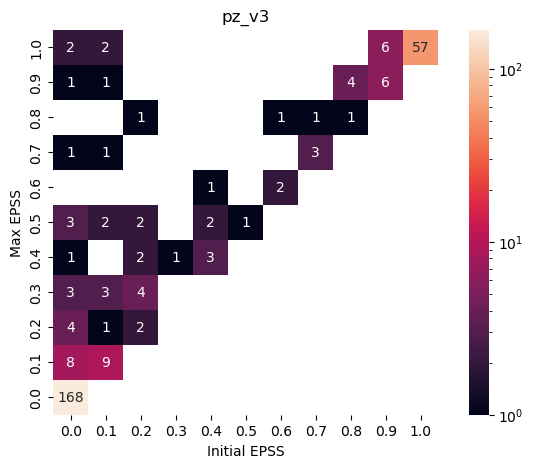

In [46]:
heatmap_initial_vs_max_epss(df_pz, 'pz_v3')

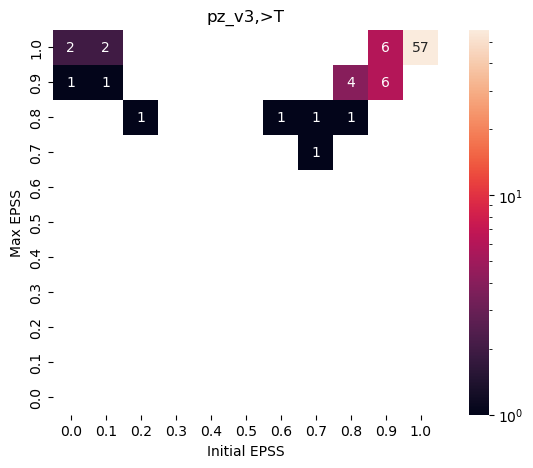

In [47]:
heatmap_initial_vs_max_epss(df_highest_pz, 'pz_v3,>T')

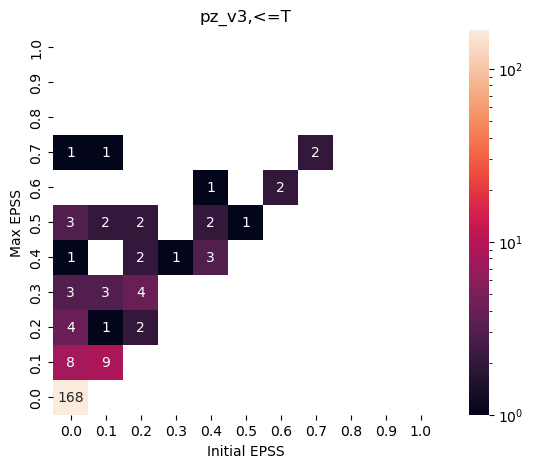

In [48]:
heatmap_initial_vs_max_epss(df_lowest_pz, 'pz_v3,<=T')

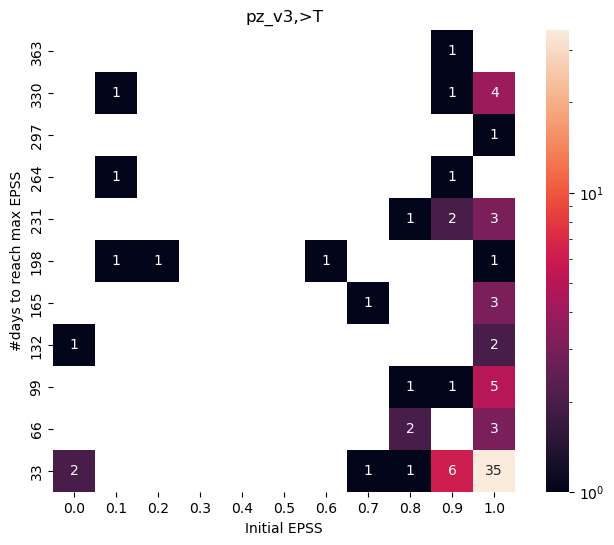

In [49]:
heatmap_epss_initial_vs_days_needed(df_highest_pz, 'pz_v3,>T')

## CISA KEV

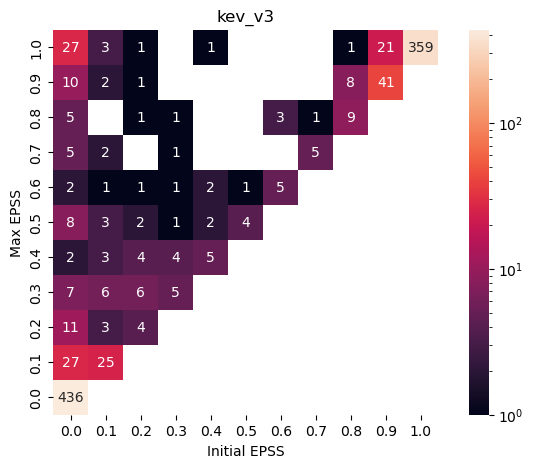

In [50]:
heatmap_initial_vs_max_epss(df_kev, 'kev_v3')

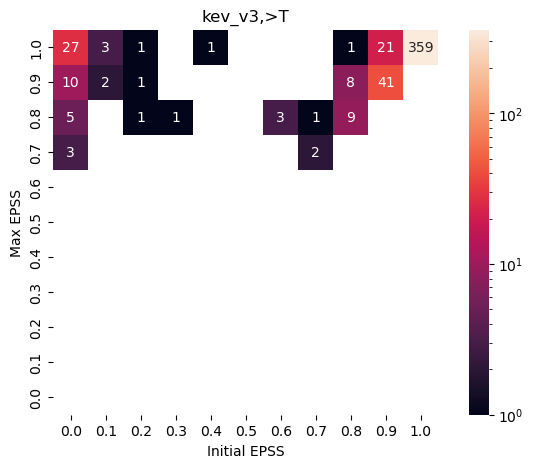

In [51]:
heatmap_initial_vs_max_epss(df_highest_kev, 'kev_v3,>T')

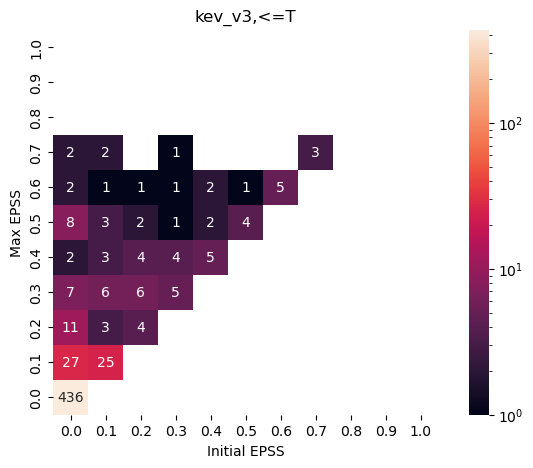

In [52]:
heatmap_initial_vs_max_epss(df_lowest_kev, 'kev_v3,<=T')

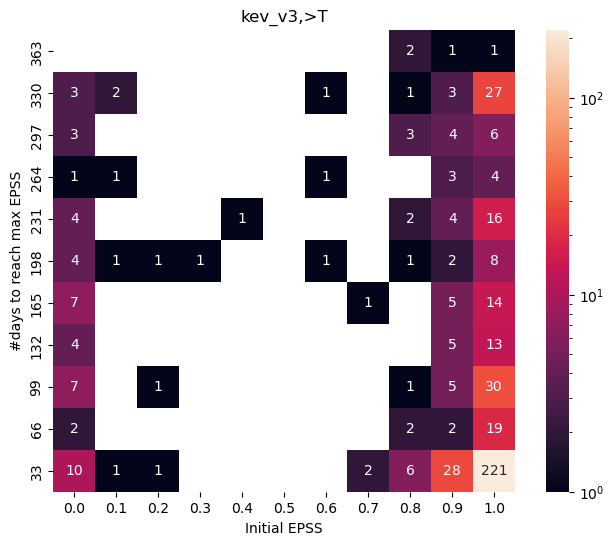

In [53]:
heatmap_epss_initial_vs_days_needed(df_highest_kev, 'kev_v3,>T')